# Plotting Vertical Profiles

In [1]:
import sys, os, glob
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)

In [2]:
import pylab as plt
import seaborn as sns
import importlib

sns.set_context('talk')

colors = plt.rcParamsDefault["axes.prop_cycle"].by_key()["color"]
ora = colors.pop(1)
colors.insert(2, ora)

myPara = {'figure.figsize': (14,7), 'lines.linewidth': 3, 'legend.frameon' : False,
          'axes.spines.right': False,
          'axes.spines.top': False,
          'axes.titleweight': 'bold',
          "axes.prop_cycle": plt.cycler(color=colors)
         }
                            
plt.rcParams.update( myPara )



## Open Data

In [3]:
sys.path.append('../tools')

import importlib
import reader, plot, analysis
importlib.reload( reader )
importlib.reload( plot )
importlib.reload( analysis )

<module 'analysis' from '/home/b/b380352/pub/2022-11_WiFi-AUS_Circ-Feedbacks/nbooks/../tools/analysis.py'>

In [4]:
ls ~/data/wifi-aus/statistics

all-echam-by-latitude.nc
burden-and-forcings-for.maps.nc
circulation-vars-by-latitude-and-pressure.nc
hydrovars-by-latitude.nc
momentum-vars-by-latitude-and-pressure.nc
radfluxes-by-latitude.nc
stratospheric-heating-rates-by-time.nc
temperature-perturbations-by-latitude.nc
uvt_tmean_wifiaus_ham_long_nu_3.4gfas2020_inj14km_dj_ao.nc
uvt_tmean_wifiaus_ham_long_nu_gfas2020_inj14km_dj_0ao.nc
uvt_tmean_wifiaus_ham_long_nu_gfas2020_inj14km_dj_ao.nc
uvt_tmean_wifiaus_ham_long_nu_gfas2020.nc
wifi-aus_band-average-aod_lsm.nc
wifi-aus_band-average-aod_no-lsm.nc
wifiaus-combined-vars-latrange.nc
w_tmean_wifiaus_ham_long_nu_3.4gfas2020_inj14km_dj_ao_activ.nc
w_tmean_wifiaus_ham_long_nu_gfas2020_activ.nc
w_tmean_wifiaus_ham_long_nu_gfas2020_inj14km_dj_0ao_activ.nc
w_tmean_wifiaus_ham_long_nu_gfas2020_inj14km_dj_ao_activ.nc


In [5]:
input_dir = '~/data/wifi-aus/statistics/'

dset = xr.open_dataset( f'{input_dir}/all-echam-by-latitude.nc',)
circ = xr.open_dataset( f'{input_dir}/circulation-vars-by-latitude-and-pressure.nc',)



In [6]:
A = dset['hyam']
B = dset['hybm']

p = A + B * dset['aps']
p = p.rename({'nhym':'lev'})

pmean = p.mean(('time', 'lat', 'mode', 'ensemble')).squeeze()
pmean = pmean / 1e2   # conversion into hPa
pmean.attrs['units'] = 'hPa'

dset = dset.assign_coords( {'lev': pmean.data})
dset = dset.rename( {'lev': 'pressure'})



In [7]:
cpressure = circ.plev * 1e-2   # transformation to hPa
circ = circ.assign_coords( {'plev': cpressure})
circ = circ.rename( {'plev': 'pressure'})

In [8]:
dset = dset.sel( pressure = slice(10,1000))
circ = circ.sel( pressure = slice(10,1000))

In [9]:
for vname in dset.data_vars:
    v = dset[vname]
    if 'pressure' in v.dims:
        print( vname, v.long_name )
        
for vname in circ.data_vars:
    v = circ[vname]
    if 'pressure' in v.dims:
        try:
            print( vname, v.long_name )
        except:
            print( vname )


q specific humidity
xl cloud water
xi cloud ice
relhum relative humidity
aclcac cloud cover
ao3 ipcc ozone
tpot potential temperature
geopoth geopotential height
t temperature
u u-velocity
v v-velocity
omega vertical velocity
tpot potential temperature
uu
uv
uomega
utheta
vv
vomega
vtheta
ww
wtheta
dtdt_vdiff v-wind tend. due to vert. diff.
dtdt_hines temperature tend. due to Hines g.w.
dtdt_sso temperature tend. due to oro. waves
dtdt_cucall temperature tend. due to convection
dtdt_cloud temp. tend. due to clouds
dtdt_rheat_sw temperature tend. due to solar wavelength rad heating
dtdt_rheat_lw temperature tend. due to thermal wavelength rad heating
v_star v-velocity
omega_star vertical velocity
diabatic_heating
EPF_phi latitude
EPF_p latitude
div_EPF latitude
psi_Eulerian latitude
psi_TEM latitude


## Plotting Function

In [10]:
def plot_profs( vstats, axs = None, label = None, title = None, scale = 1., plotscale = 'linear', 
                plot_legend = False, ticks = None, relative = False ):
    
    months = ['Jan', 'Feb', 'Mar']
    cols = ['C0', 'C1', 'C2', 'C3']

    if axs is None:
        fig, axs = plt.subplots(ncols = 3, figsize = (12,6), sharey = True, sharex = True,)

    plt.subplots_adjust( left = 0.2, hspace = 1., wspace = 0.1, top = 0.85, right = 0.8, bottom = 0.15)

    for i, t in enumerate( vm.time ):
        a = axs[i]
        v = scale * vstats.sel(stats = 'nudged', time = t)
        
        if relative:
            vref =  scale * vstats.sel(stats = 'nudged-reference', time = t)
            v = 100.* v / vref
            
        v.plot( hue = 'mode', y = 'pressure', yincrease = False, ax = a, lw = 1, add_legend = False  )
        plt.sca(a)
        plt.title(months[i])
        plt.axvline(0, color = 'gray', lw = 6, alpha = 0.3)

        if i == 0:
            a.set_ylabel('pressure / (hPa)')
        else:
            a.set_ylabel('')
            a.spines.left.set_visible(False)
            a.tick_params(left=False)
            
        if i != 1:
            a.set_xlabel('')
        else:
                        
            if label is not None:
                a.set_xlabel(label, labelpad = 15 )
        
        a.set_xscale( plotscale )
            
        lines = []
        for im, mode in enumerate(vstats.mode):
            kws = dict(time = t, mode = mode)
            v1 = scale * vstats.sel(stats = 'lower', **kws)
            vmean = scale * vstats.sel(stats = 'mean', **kws)
            v2 = scale * vstats.sel(stats = 'upper', **kws)
            
            if relative:
                vref = scale * vstats.sel(stats = 'reference', **kws)
                v1 = 100.* v1 / vref
                vmean = 100.* vmean / vref
                v2 = 100.* v2 / vref
                
            p = vstats.pressure
            li, = plt.plot( vmean,p, lw = 5, color = cols[im], zorder = 5-im, label = mode.data)
            plt.fill_betweenx(p, v1, v2, alpha = 0.3, color = cols[im])

            lines +=[li,]
            
        if ticks is not None:
            a.set_xticks( ticks)
            a.set_xticklabels(ticks)
            
        if title is not None:
            plt.suptitle(title, fontsize = 22, fontweight = 'bold')
        
        if plot_legend and i == 2:
            handles, labels = axs[0].get_legend_handles_labels()
            nlabels = plot.standardize_firenames( labels )
            plt.legend(loc = 'center left', labels = nlabels, handles = lines, bbox_to_anchor = (1.1, 0.5), fontsize = 22 )
            

## Plots for Paper 

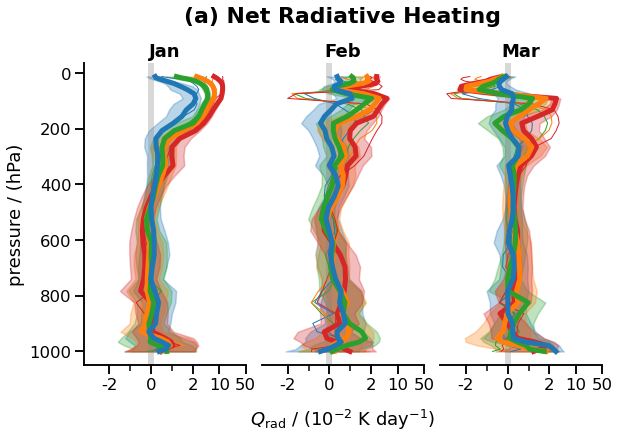

In [11]:
scaling = circ['tpot'] / circ['t']
Q = circ['dtdt_rheat_sw'] + circ['dtdt_rheat_lw']
J = scaling * Q

vm = analysis.glob_mean( Q )
vstats = analysis.stats_and_nudged( vm )
ticks = [-2, 0, 2, 10, 50]
plot_profs (vstats, label = r'$Q_\mathrm{rad}$ / ($10^{-2}$ K day${}^{-1})$', plotscale = 'symlog', title = '(a) Net Radiative Heating', ticks = ticks, scale = 100)

plt.savefig('../pics/profile_heating.png', dpi = 600)

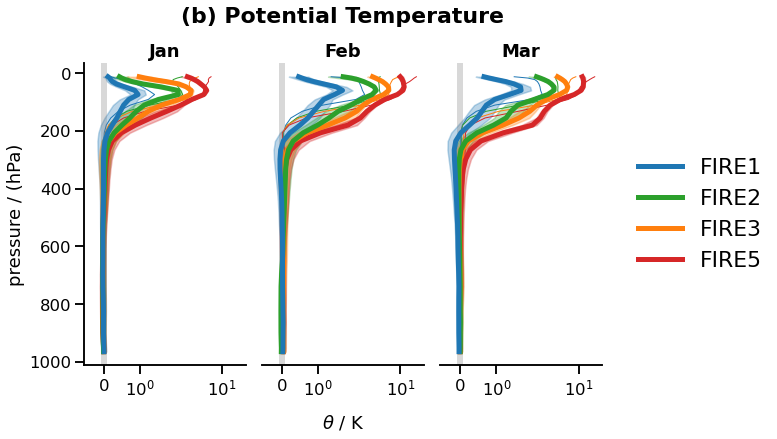

In [12]:
vname = 'tpot'
vm = analysis.glob_mean( dset[vname] )
vstats = analysis.stats_and_nudged( vm ).squeeze()
plot_profs (vstats, label = r'$\theta$ / K', plotscale = 'symlog', title = '(b) Potential Temperature', plot_legend = True)
plt.savefig('../pics/profile_tpot.png', dpi = 600)

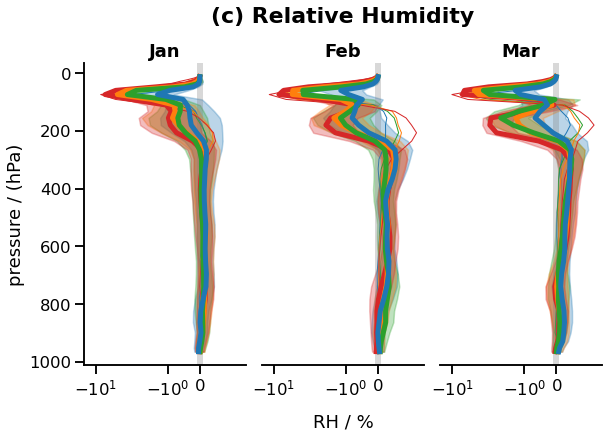

In [13]:
vname = 'relhum'
vm = analysis.glob_mean( dset[vname] )
vstats = analysis.stats_and_nudged( vm ).squeeze()
plot_profs (vstats, label = r'RH / %', plotscale = 'symlog', title = '(c) Relative Humidity', scale = 100.)
plt.savefig('../pics/profile_RH.png', dpi = 600)

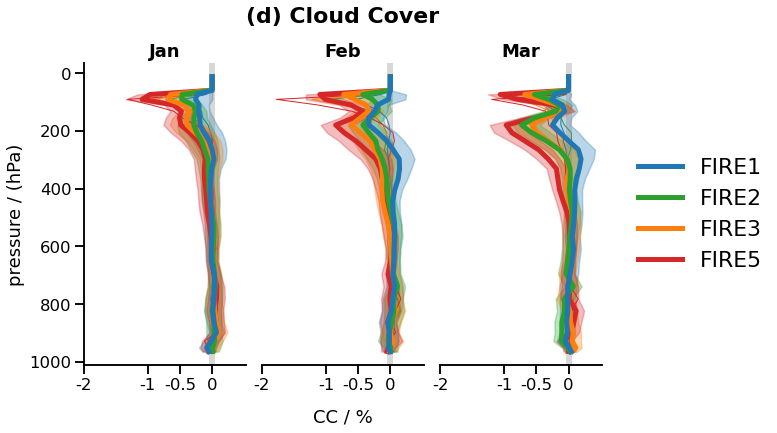

In [14]:
vname = 'aclcac'
vm = analysis.glob_mean( dset[vname] )
vstats = analysis.stats_and_nudged( vm ).squeeze()
ticks = [-2, -1, -0.5, 0]
plot_profs (vstats, label = r'CC / %', plotscale = 'symlog', title = '(d) Cloud Cover', scale = 1e2, ticks = ticks, plot_legend = True)
plt.savefig('../pics/profile_CC.png', dpi = 600)


## Plots for Supplement 

In [15]:
theta = circ['tpot']

# calculate stability
Gamma = theta.differentiate('pressure')

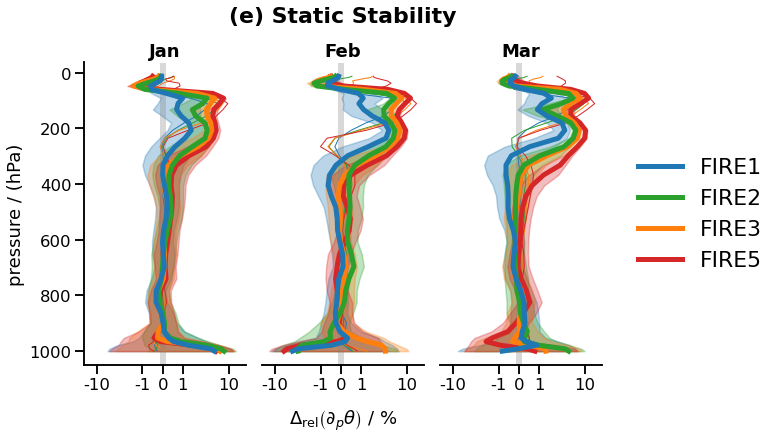

In [16]:
vm = analysis.glob_mean( Gamma )
vstats = analysis.stats_and_nudged( vm )
ticks = [-10, -1,  0, 1, 10]
plot_profs (vstats, label = r'$\Delta_\mathrm{rel}\left(\partial_p\theta\right)$ / %', plotscale = 'symlog', title = '(e) Static Stability', scale = 1e2, 
            ticks = ticks, plot_legend = True, relative = True)
plt.savefig('../pics/profile_Gamma.png', dpi = 600)

* reference stability

Text(-10, 100, '$\\Gamma$(100 hPa) = -1.1 K / hPa')

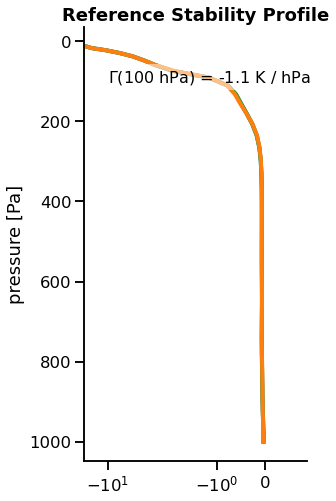

In [17]:
vstats.sel( stats = 'reference', mode = 'fire1.0').plot( y = 'pressure', add_legend = False, xscale = 'symlog',
                                                         hue = 'time', figsize = (4,8), yincrease = False, lw = 4)
plt.title('Reference Stability Profile')

Gamma100 = vstats.sel( stats = 'reference', mode = 'fire1.0').sel(pressure = 100, method = 'nearest').mean('time')

plt.text(-10, 100, '$\Gamma$(100 hPa) = %.1f K / hPa' % Gamma100.data, fontsize = 16, bbox=dict(facecolor='w', alpha=0.5,lw = 0))